In [1]:
from IPython import display
import random
import numpy as np
import torch
import pickle
import timeit
import time
import argparse
import pprint
from pathlib import Path
from confs import fn, fn2, fn22, LogFn, sigma
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
import numpy.random as npr
from utilsNew import *

In [2]:
import matplotlib.pyplot as plt
import pickle

In [3]:
cudaid = 2
torch.cuda.set_device(cudaid)
torch.manual_seed(0) # cpu
torch.cuda.manual_seed(0) #gpu
np.random.seed(0) #numpy
random.seed(0) #random and transforms
torch.backends.cudnn.deterministic=True # cudnn

In [4]:
cuda = torch.cuda.is_available()
if cuda:
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [72]:
def fRun(R, CT, Cb, etaT, etab, maxIter=100, is_plot=False, is_showPro=False):
    LamT = LamTfn(CT, n, m, p)
    Lamb = Lambfn(Cb, n, m)
    betaOld, bThetaOld = betainit, bThetainit
    
    
    reCh = 10
    Losses = []
    betaDiffs = []
    bThetaDiffs = []
    betaErrs = []
    bThetaErrs = []
    betaL0s = []
    bThetaRanks = []
    
    if is_showPro:
        IterShowBar = tqdm(range(maxIter))
    else:
        IterShowBar = range(maxIter)
    for t in IterShowBar:
        betaOldN0 = len(betaOld.nonzero())
        t0 = time.time()
        if betaOldN0 <= 10:
            LvNow = lossLBern(bThetaOld, betaOld, f, X, Y, R, probs=prob, fct=fct, is_logf=False)
        else:
            LvNow = lossL(bThetaOld, betaOld, f, X, Y, R, fct=fct, is_logf=False)
        
        t1 = time.time()
        # update beta
        if betaOldN0 <= 10:
            LpbvOld = lossLpbBern(bThetaOld, betaOld, conDenfs[:3], X, Y, R, probs=prob, fct=fct)
        else:
            LpbvOld = lossLpb(bThetaOld, betaOld, conDenfs[:3], X, Y, R, fct=fct)
        betaNewRaw = betaOld - etab * LpbvOld
        betaNew = SoftTO(betaNewRaw, etab*Lamb)
        #print(betaNewRaw, etab*Lamb)
        #print(betaNew, (etab*Lamb).item())
       
        t2 = time.time()
        betaNewN0 = len(betaNew.nonzero())
        if betaNewN0 <= 10:
            LpTvOld = lossLpTBern(bThetaOld, betaNew, conDenfs[:3], X, Y, R, probs=prob, fct=fct)
        else:
            LpTvOld = lossLpT(bThetaOld, betaNew, conDenfs[:3], X, Y, R, fct=fct)
       
        t3 = time.time()
        # update Theta
        #svdres = torch.svd(bThetaOld-LpTvOld*etaT)
        svdres = torch.svd_lowrank(bThetaOld-LpTvOld*etaT, q=10) # it can be very  fast
        U, S, V =  svdres
        softS = (S-LamT*etaT).clamp_min(0)
        bThetaNew = U.matmul(torch.diag(softS)).matmul(V.t())
        
        LossNow = LossWP(LvNow, softS, betaNew, LamT, Lamb)
        Losses.append(LossNow.item())
        t4 = time.time()
        
        ts = np.array([t0, t1, t2, t3, t4])
        #print(np.diff(ts), torch.matrix_rank(bThetaOld))
    
        if t >= 1:
            Lk1 = Losses[-1]
            Lk = Losses[-2]
            reCh = np.abs(Lk1-Lk)/np.max(np.abs((Lk, Lk1, 1))) 
        betaDiff = (betaOld-betaNew).norm().item()/(betaNew.norm().item()+1e-6)
        bThetaDiff = (bThetaOld-bThetaNew).norm().item()/(bThetaNew.norm().item()+1e-6)
        betaDiffs.append(betaDiff)
        bThetaDiffs.append(bThetaDiff)
        betaErrs.append((betaNew-beta0).norm().item())
        bThetaErrs.append((bThetaNew-bTheta0).norm().item())
        betaL0s.append(len(torch.nonzero(betaNew)))
        bThetaRanks.append(torch.linalg.matrix_rank(bThetaNew).item())
        
        betaOld, bThetaOld = betaNew, bThetaNew 
        etaT = etaT * 0.96
        etab = etab * 0.95
        
        
        # plot res
        if t >= 1 and is_plot:
            plt.figure(figsize=[15, 10])
            
            plt.subplot(231)
            plt.xlim([0, maxIter])
            #plt.ylim([-10, 5])
            plt.title("Loss Diff")
            lossDifs = np.log(np.abs(np.diff(Losses)))
            plt.plot(list(range(0, t)), lossDifs)
            plt.scatter(t-1, lossDifs[-1], color="red", s=20)
            plt.axhline(y=np.log(tol), color="green", linewidth=2, linestyle='--')
            
            plt.subplot(232)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Beta Err")
            betaErrsArr = np.log(np.array(betaErrs))
            plt.plot(list(range(0, t+1)), betaErrsArr)
            plt.scatter(t, betaErrsArr[-1], color="red", s=20)
            plt.text(t, betaErrsArr[-1], f"Error is {np.exp(betaErrsArr[-1]):.3e}")
            
            plt.subplot(233)
            plt.xlim([0, maxIter])
            #plt.ylim([-5, 0])
            plt.title("Theta Err")
            bThetaErrsArr = np.log(np.array(bThetaErrs))
            plt.plot(list(range(0, t+1)), bThetaErrsArr)
            plt.scatter(t, bThetaErrsArr[-1], color="red", s=20)
            plt.text(t, bThetaErrsArr[-1], f"Error is {np.exp(bThetaErrsArr[-1]):.3e}")
            
            plt.subplot(235)
            plt.xlim([0, maxIter])
            #plt.ylim([0, p])
            plt.title("Beta L0")
            plt.plot(list(range(0, t+1)), betaL0s)
            plt.scatter(t, betaL0s[-1], color="red", s=20)
            plt.text(t, betaL0s[-1], f"L0 norm is {betaL0s[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            plt.subplot(236)
            plt.xlim([0, maxIter])
            #plt.ylim([0, np.min([n, m])])
            plt.title("Theta Rank")
            plt.plot(list(range(0, t+1)), bThetaRanks)
            plt.scatter(t, bThetaRanks[-1], color="red", s=20)
            plt.text(t, bThetaRanks[-1], f"rank is {bThetaRanks[-1]:.0f}")
            plt.axhline(y=5, color="green", linewidth=2, linestyle='--')
            
            #if (reCh >= tol) and ((bThetaDiff >= tolT) or (betaDiff >= tolb)) and (t<=(maxIter-1)):
            display.clear_output(wait=True)
            plt.pause(1e-7)
            
        if (reCh < tol):
            break
        if (bThetaDiff < tolT) and (betaDiff < tolb):
            break
    
    res = {}
    res["beta"] = betaNew.cpu().numpy()
    res["bTheta"] = bThetaNew.cpu().numpy()
    res["IterNum"] = t
    res["betaDiffs"] = betaDiffs
    res["bThetaDiffs"] = bThetaDiffs
    res["betaErrs"] = betaErrs
    res["bThetaErrs"] = bThetaErrs
    res["loss"] = Losses
    res["betaNorm0"] = len(torch.nonzero(betaNew))
    res["bThetaRank"] = torch.linalg.matrix_rank(bThetaNew).item()
    return res

In [73]:
def genR2(Y, D=3):
    probs = torch.zeros_like(Y)
    Ystd = Y - torch.mean(Y)
    probs = torch.exp(Ystd - D)
    probs = probs/(1 + probs)
    #probs[Ystd<0]
    uniSps = torch.rand_like(probs)
    R = uniSps <= probs
    R = R.type_as(Y).to_sparse()
    return R

In [196]:
n = m = 100
p = 50
prob = 0.2

sigmaY = 5.0

# generate the parameters
beta0 = torch.cat((torch.tensor([1.0, 0, 2, 0, -3, -4, 5]), torch.zeros(p-7))) 
bTheta0 = genbTheta(n, m, sigVs=np.array([50, 9, 8, 7, 6])*10)/50
initbetapref = 1 + (torch.rand(p)-1/2)/1 #[0.875, 1.125]
initthetapref = 1 + (torch.rand(n, m)-1/2)/4
betainit = beta0 * initbetapref
bThetainit = bTheta0 * initthetapref

X = genXBin(n, m, p, prob=prob) 
Y = genYnorm(X, bTheta0, beta0, sigmaY)
R = genR2(Y, D=7.8)
R.to_dense().mean()

tensor(0.1015)

In [75]:
def f(y, m, bsXs=None, sigma=sigmaY):
    return fn(y, m, bsXs, sigma)
def f2(y, m, bsXs=None, sigma=sigmaY):
    return fn2(y, m, bsXs, sigma)
conDenfs = [f, f2, fn22]

In [76]:
import time

tol = 0
tolT = 0
tolb = 0
paraXMNAR = [1e-3, 5e2, 1.3e2, 1] 
p = 10
fct = 1
mns = [100, 200, 400, 800, 1600, 3200, 6400]
mns = [2200, 2400, 2600, 2800, 3000]
tss = []
for n in mns[::]:
    m = n
    
    beta0 = torch.cat((torch.tensor([1.0, 0, 2, 0, -3, -4, 5]), torch.zeros(p-7))) 
    bTheta0 = genbTheta(n, m, sigVs=np.array([50, 9, 8, 7, 6])*10)/50
    
    ts = []
    for j in tqdm(range(5)):
        initbetapref = 1 + (torch.rand(p)-1/2)/1
        initthetapref = 1 + (torch.rand(n, m)-1/2)/4
        betainit = beta0 * initbetapref
        bThetainit = bTheta0 * initthetapref
        X = genXBin(n, m, p, prob=prob) 
        Y = genYnorm(X, bTheta0, beta0, sigmaY)
        R = genR2(Y, D=7.8)
        t0 = time.time()
        resMNAR = fRun(R, CT=paraXMNAR[0], Cb=paraXMNAR[1], etaT=paraXMNAR[2], etab=paraXMNAR[3], maxIter=50, is_plot=0, is_showPro=0)
        t1 = time.time()
        ts.append(t1-t0)
    tss.append(ts)

tsM = [np.mean(ts)/50 for ts in tss]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
with open("timevsMN.pkl", "wb") as sf:
    pickle.dump([mns, tsM], sf)

In [174]:
with open("timevsMN.pkl", "rb") as sf:
    mns, tsM= pickle.load(sf)

In [156]:

x = np.array(mns[:])
x = np.array([x, x**2]).T

In [159]:
import statsmodels.api as sm
y = np.array(tsM[:]) 
#x = np.log(mns[:])
x = np.array(mns[:])
x = np.array([x, x**2]).T
#x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              778.2
Date:                Thu, 31 Mar 2022   Prob (F-statistic):                    2.94e-14
Time:                        14:53:47   Log-Likelihood:                          50.858
No. Observations:                  15   AIC:                                     -97.72
Df Residuals:                      13   BIC:                                     -96.30
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          5.044e-05   7.21e-06      6.992      0.000    3.49e-05     6.6e-05
x2          2.188e-08   4.62e-09      4.731      0.000    1.19e-08    3.19e-08
==============================================================================
Omnibus:                        1.614   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.446   Jarque-Bera (JB):                1.254
Skew:                           0.641   Prob(JB):                        0.534
Kurtosis:                       2.398   Cond. No.                     5.31e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [152]:
yhat = np.exp(-17 +2 * np.log(mns[:]))
#yhat = np.exp(model.params[0] +model.params[-1] * np.array(mns[:]))

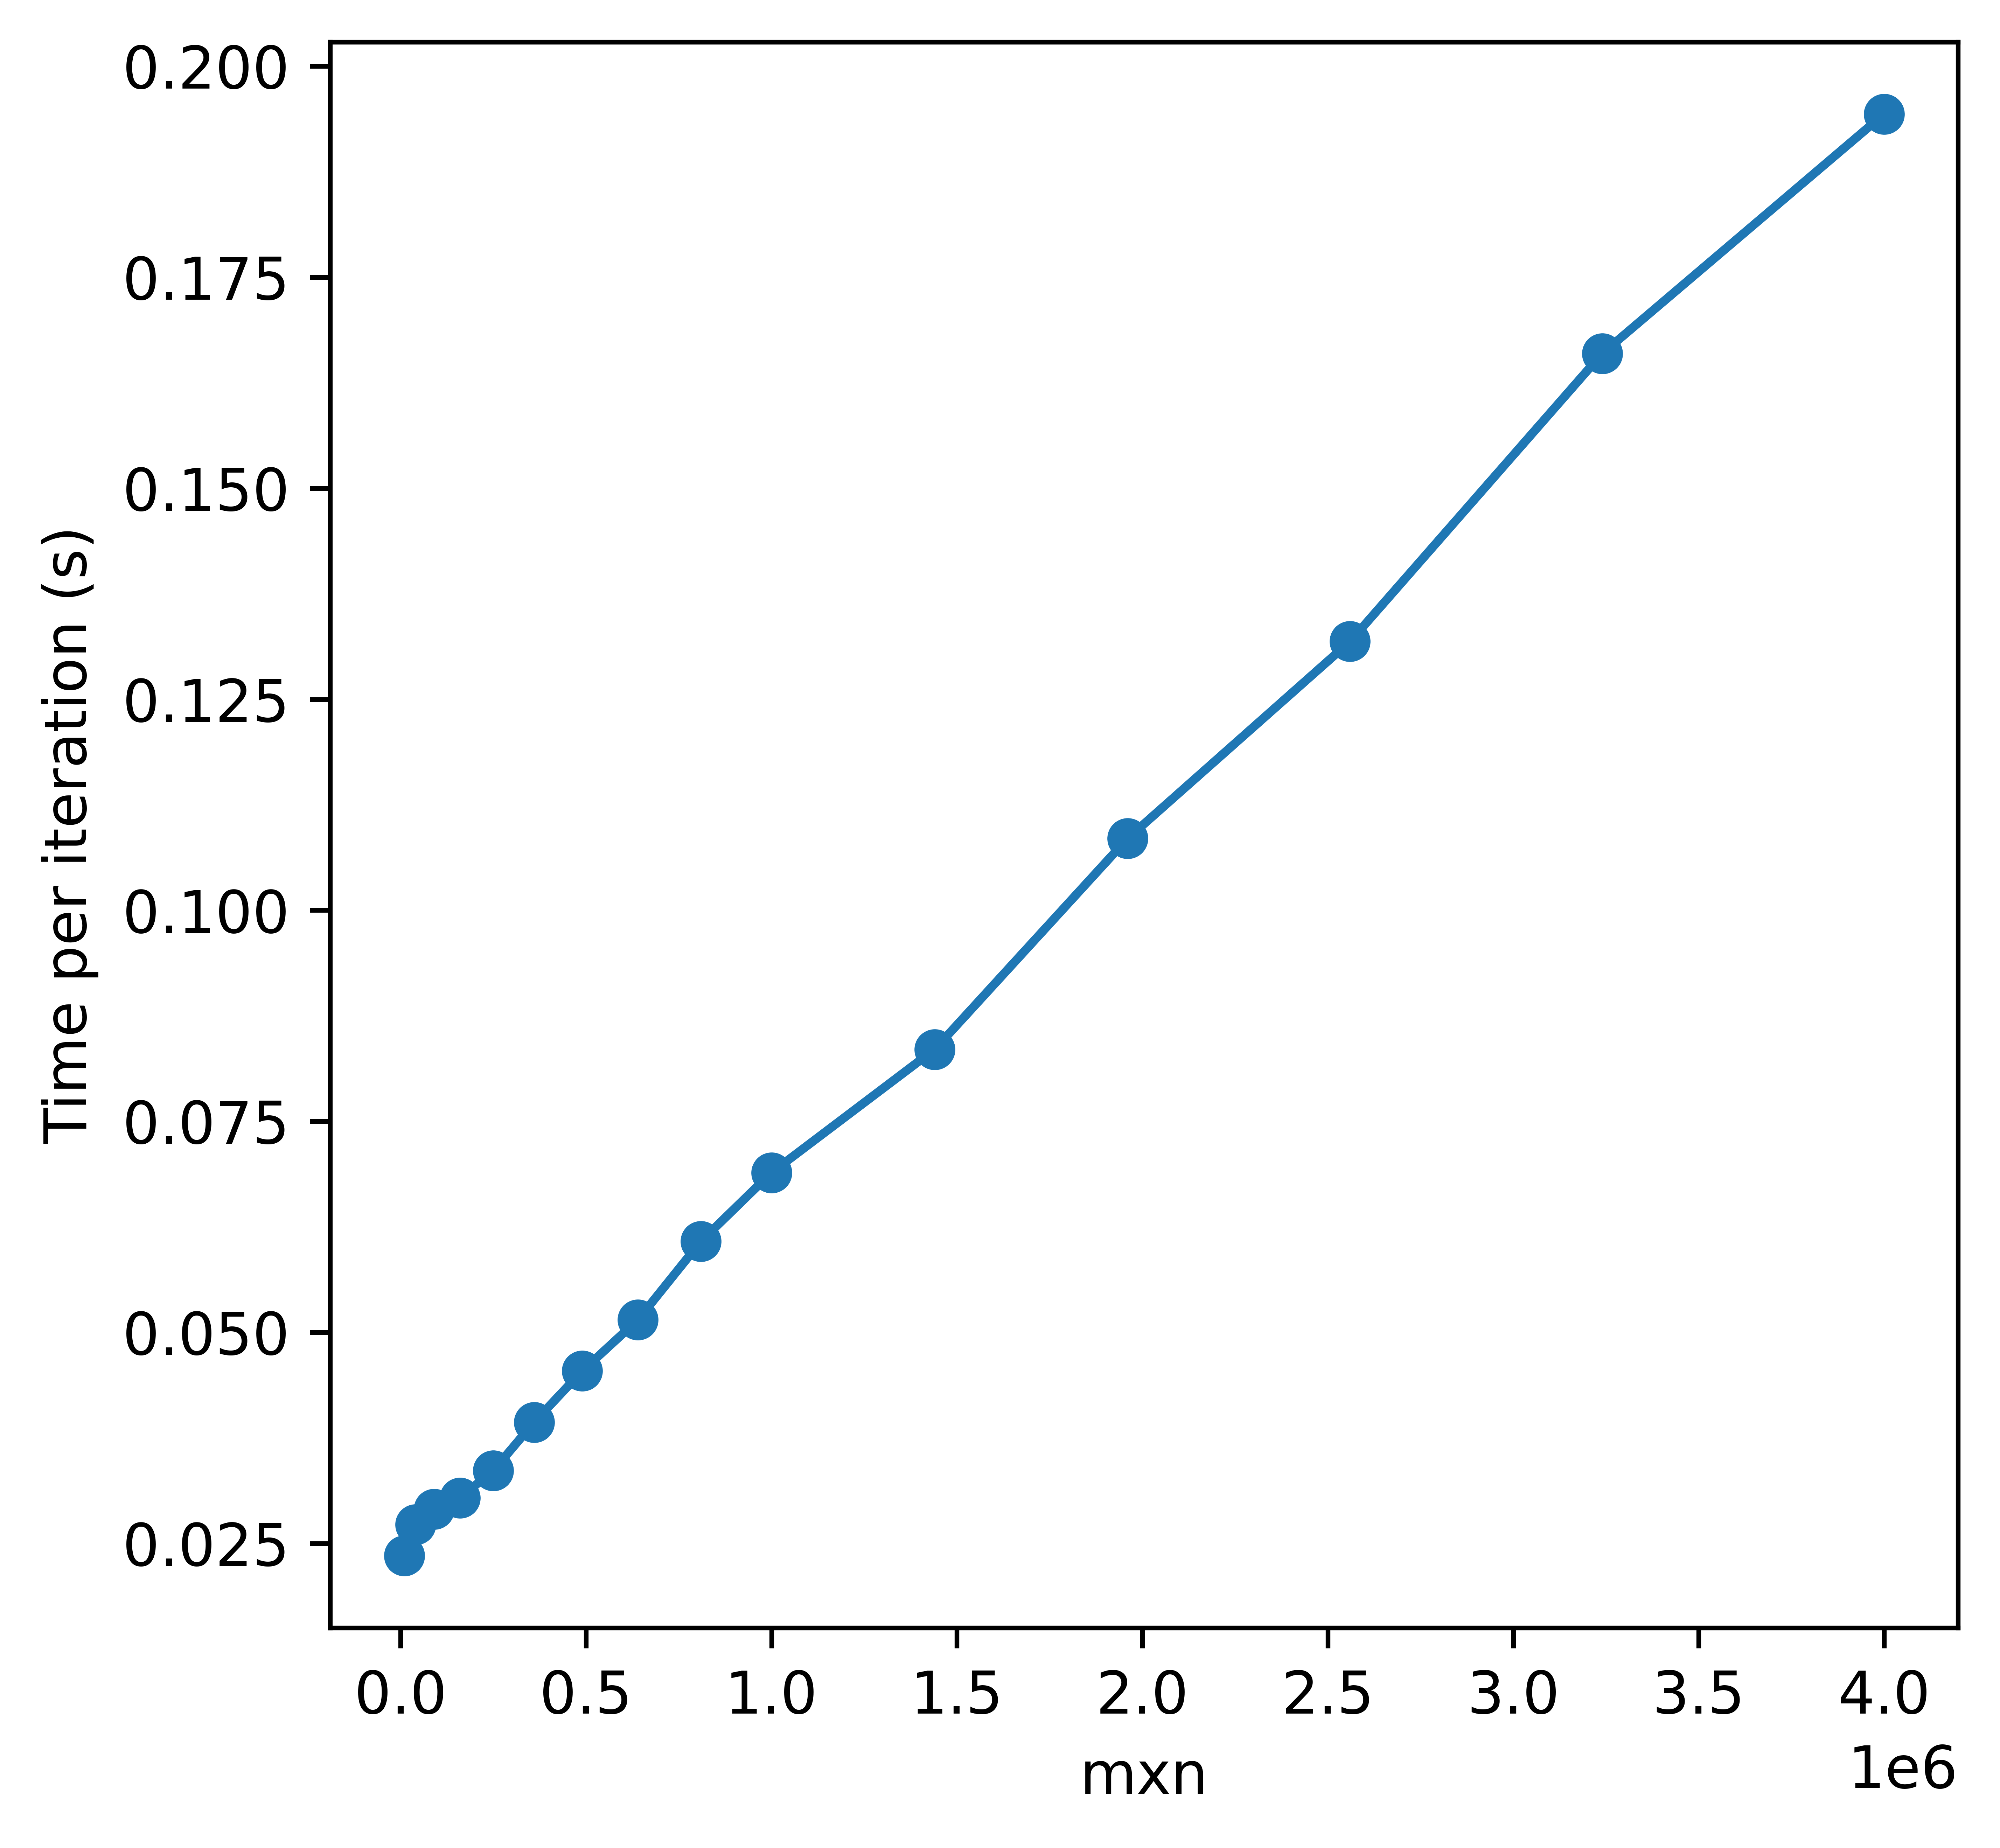

In [175]:
plt.figure(figsize=[5, 5], dpi=1200)
plt.plot(np.array(mns[:])**2, tsM[:], "o-")
#plt.plot(mns[:], yhat, "--")
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("mxn")
plt.ylabel("Time per iteration (s)")
plt.savefig("./JMLRR3/MNvsTime.jpg", bbox_inches='tight')

In [106]:
import time

tol = 0
tolT = 0
tolb = 0
paraXMNAR = [1e-3, 5e2, 1.3e2, 1] 
p = 10
fct = 1
m = n = 100
tss = []
ps = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190]
for p in ps[::]:
    
    beta0 = torch.cat((torch.tensor([1.0, 0, 2, 0, -3, -4, 5]), torch.zeros(p-7))) 
    bTheta0 = genbTheta(n, m, sigVs=np.array([50, 9, 8, 7, 6])*10)/50
    
    ts = []
    for j in tqdm(range(5)):
        initbetapref = 1 + (torch.rand(p)-1/2)/1
        initthetapref = 1 + (torch.rand(n, m)-1/2)/4
        betainit = beta0 * initbetapref
        bThetainit = bTheta0 * initthetapref
        X = genXBin(n, m, p, prob=prob) 
        Y = genYnorm(X, bTheta0, beta0, sigmaY)
        R = genR2(Y, D=7.8)
        t0 = time.time()
        resMNAR = fRun(R, CT=paraXMNAR[0], Cb=paraXMNAR[1], etaT=paraXMNAR[2], etab=paraXMNAR[3], maxIter=50, is_plot=0, is_showPro=0)
        t1 = time.time()
        ts.append(t1-t0)
    tss.append(ts)

tsM = [np.mean(ts)/50 for ts in tss]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [107]:
with open("timevsP.pkl", "wb") as sf:
    pickle.dump([ps, tsM], sf)

In [172]:
with open("timevsP.pkl", "rb") as sf:
    ps, tsM = pickle.load(sf)

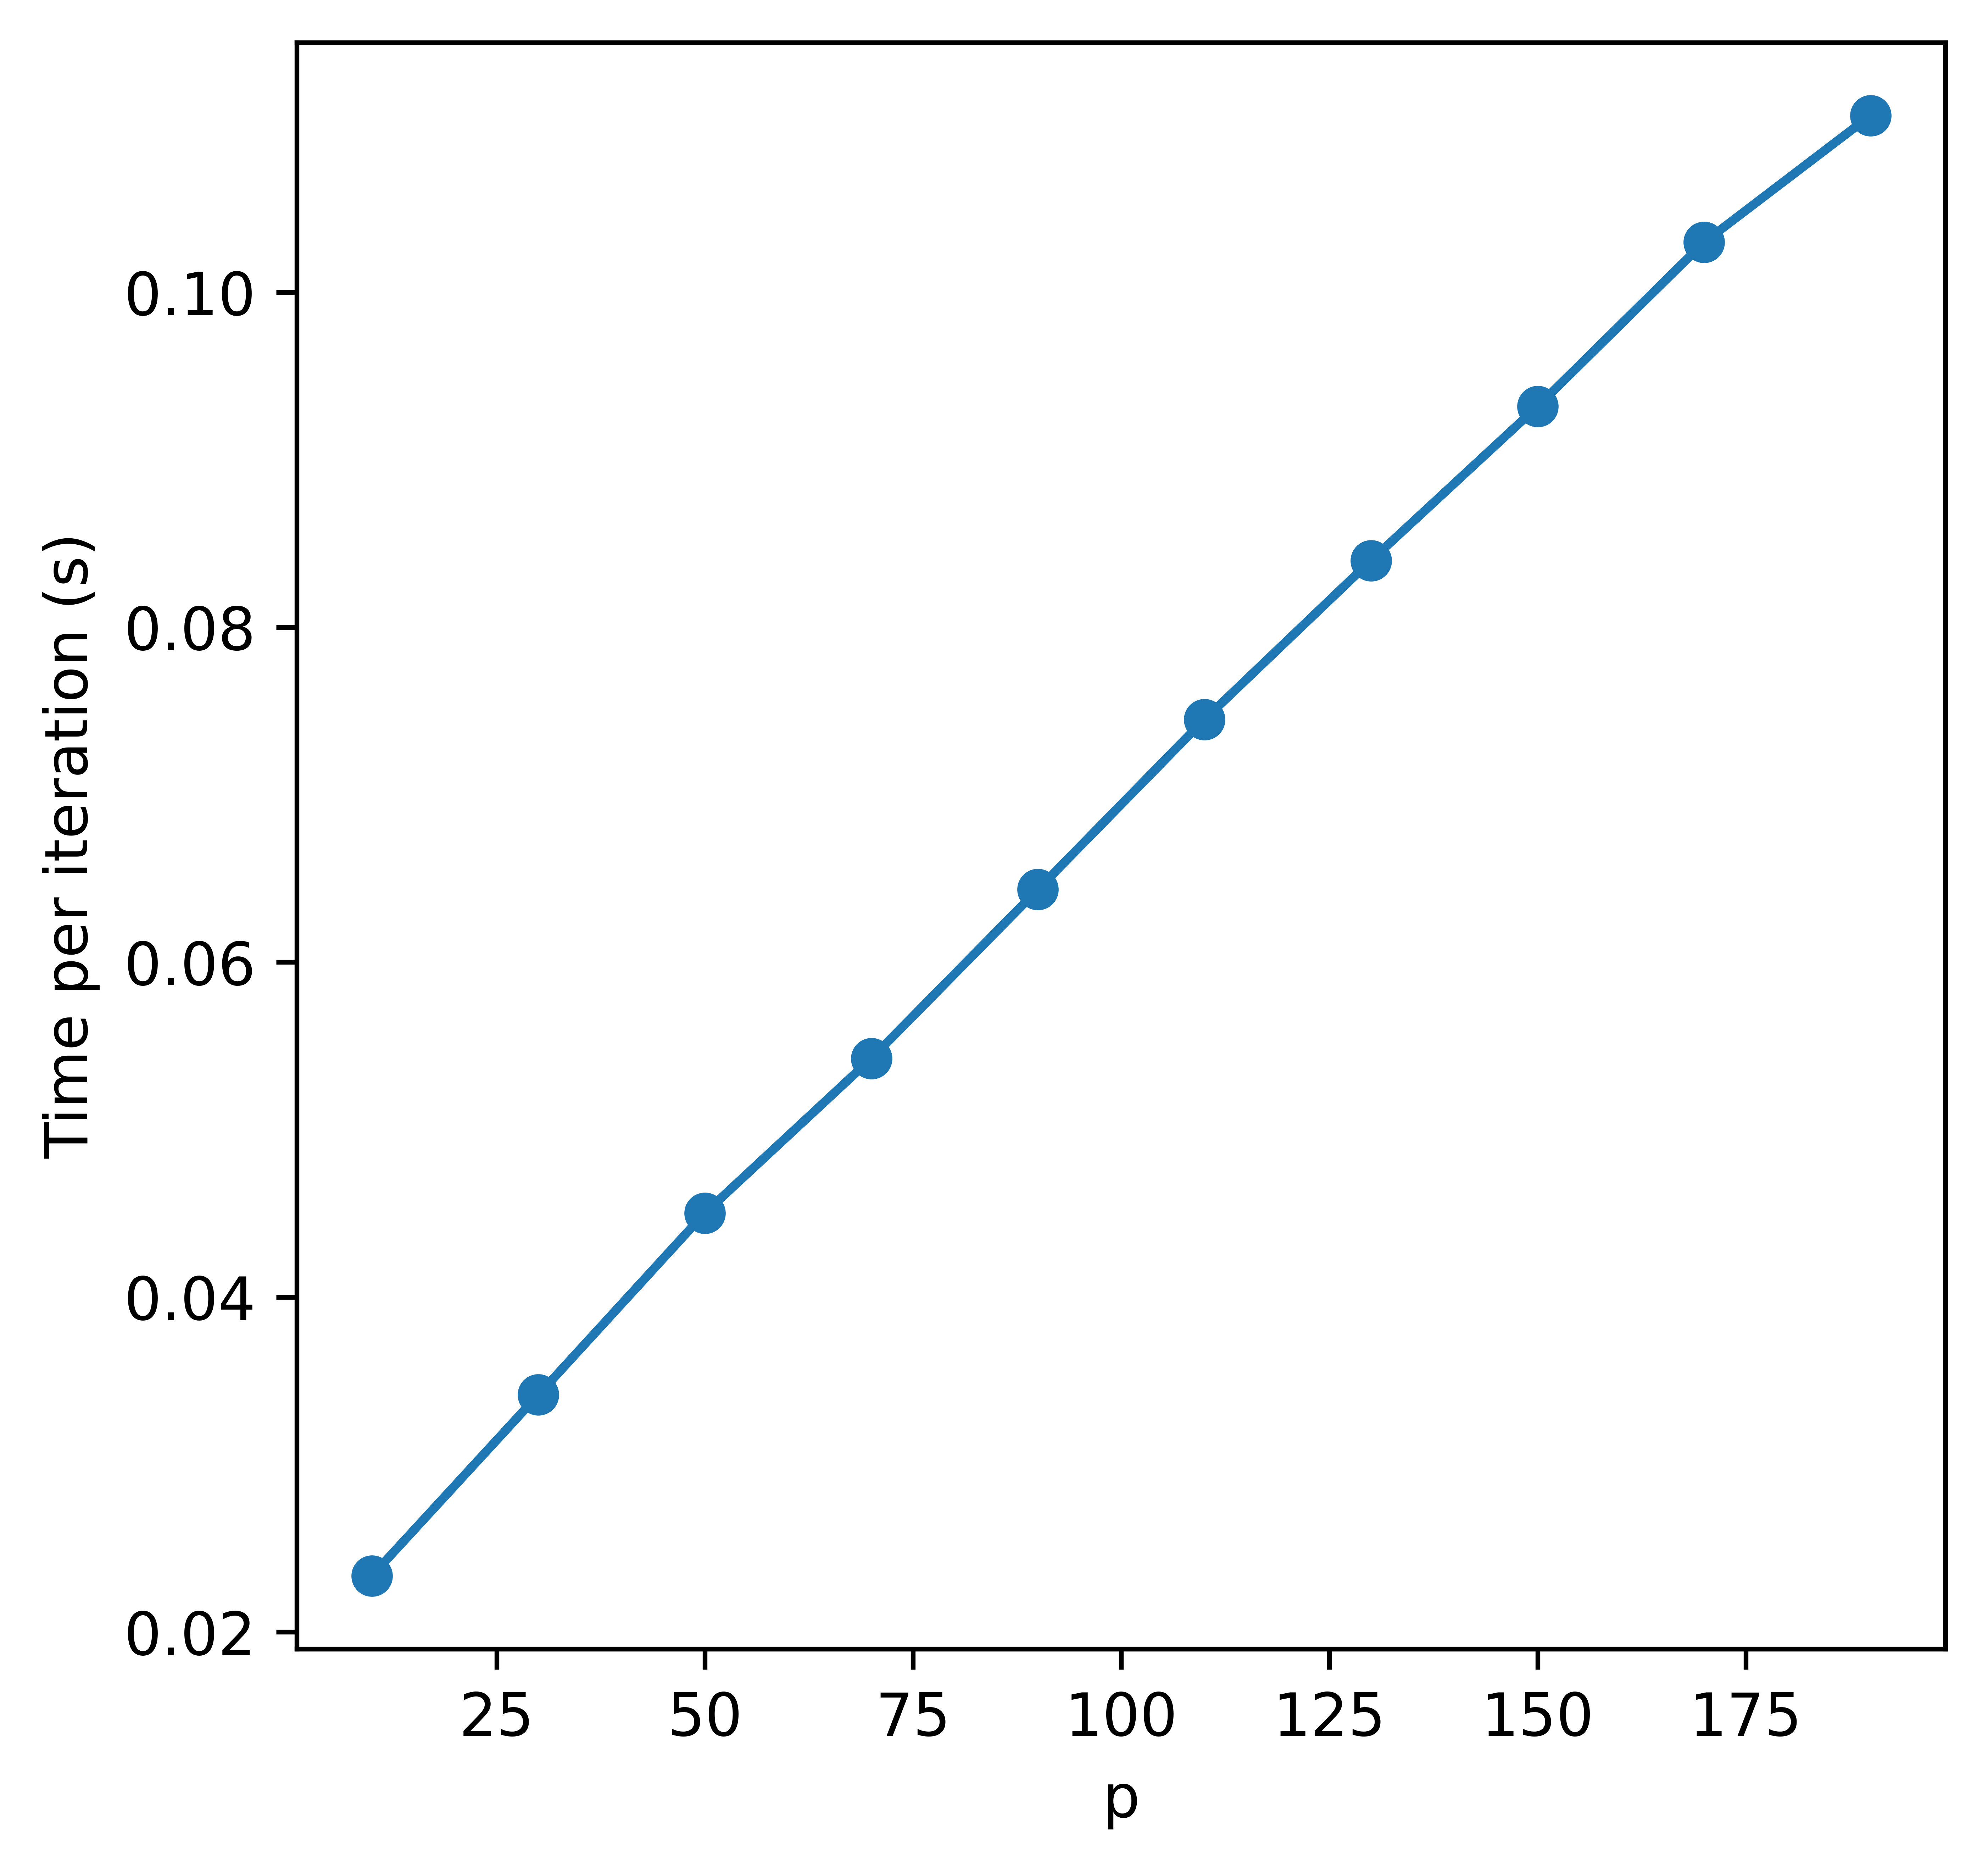

In [173]:
plt.figure(figsize=[5, 5], dpi=1200)
plt.plot(ps[:], tsM[:], "o-")
plt.xlabel("p")
plt.ylabel("Time per iteration (s)")
plt.savefig("./JMLRR3/PvsTime.jpg", bbox_inches='tight')

In [167]:
with open("timevsP.pkl", "rb") as sf:
    ps, tsM2 = pickle.load(sf)

In [168]:
with open("timevsMN.pkl", "rb") as sf:
    mns, tsM1 = pickle.load(sf)

In [169]:
nmps = np.concatenate([np.array(mns)**2*10, np.array(ps)*100*100])
tsMb = np.concatenate([tsM1, tsM2])

Text(0, 0.5, 'Time (per iteration) (s)')

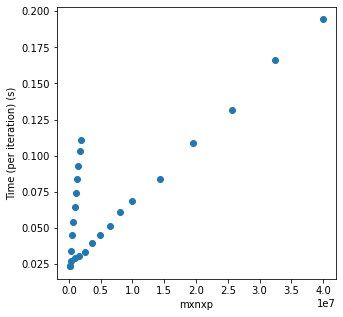

In [171]:
plt.figure(figsize=[5, 5])
plt.plot(nmps[:], tsMb[:], "o")
plt.xlabel("mxnxp")
plt.ylabel("Time (per iteration) (s)")

array([  100000,   400000,   900000,  1600000,  2500000,  3600000,
        4900000,  6400000,  8100000, 10000000, 14400000, 19600000,
       25600000, 32400000, 40000000,   100000,   300000,   500000,
         700000,   900000,  1100000,  1300000,  1500000,  1700000,
        1900000])